University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2022  
Luigi Acerbi  

# Week 1 exercises

In [13]:
# Useful imports
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.linalg import solve_triangular


rng = npr.default_rng(42)


## 1. Input ranges for overflow and underflow (4 pts)

i. Write a program to find the largest integer for which `exp()` over double precision floating point numbers (`float64`) returns a finite value.

ii. The logistic function $$ \phi(x) = \frac{1}{1 + \exp(-x)} $$ is often used to map the real line to probabilities in the range $(0, 1)$, for example in logistic regression. For real numbers, the equation $ \phi(x) = 1 $ has no solution, but the same is not true for floating point numbers on a computer. Write a program to determine the smallest integer $ x $ for which $ \phi(x) =_F 1$ when using double precision floating point (`float64`) arithmetic.

*Note*: "Write a program" means you should not try out all values manually, but program the computer to find the solution.

In [14]:
# i 
def largest_valid_exp_argument() -> int:
    # we know that np.exp(1) is valid and np.exp(1000) is an overflow, so binary search
    minn, maxx = 1, 1000
    target = np.ceil((minn/maxx)/2)
    while(True):
        if target == maxx:
            return int(minn) # our we tried to go up, but reached maxx. So minn is the correct result.
        result = np.exp(target)
        if np.isinf(result): # go down
            maxx = target
            target = np.ceil((minn+target)/2)
            
        else: # go up
            minn = target
            target = np.ceil((target+maxx)/2)
    
print(largest_valid_exp_argument())

# ii

def logistic(x: np.float_) -> np.float_:
    return (
        1 / (
            1 + np.exp(-x)
        )
    )

def find_logistic_outputs_1() -> np.int_:
    minn, maxx = 0, 1_000_000
    target = np.ceil((minn/maxx)/2)
    while(True):
        if target == maxx:
            return int(maxx)
        result = logistic(target)
        if np.equal(result, 1.0): # go down
            maxx = target
            target = np.ceil((minn+target)/2)
            
        else: # go up
            minn = target
            target = np.ceil((target+maxx)/2)

print(find_logistic_outputs_1())

709
37


/tmp/ipykernel_10063/359217853.py:9: RuntimeWarning: overflow encountered in exp
  result = np.exp(target)


## 2. Numerical computation of binomial probabilities (4 pts)

Write a computer program to compute sums of binomial probabilities:
$$ f(l, u, n, p) = \sum_{i=l}^u \binom{n}{i} p^i (1-p)^{n-i}. $$
Use it to compute:

i. $ f(0, 5, 10, 0.25) = \sum_{i=0}^{5} \binom{10}{i} 0.25^i 0.75^{10-i} $

ii. $ f(10, 20, 20, 0.25) = \sum_{i=10}^{20} \binom{20}{i} 0.25^i 0.75^{20-i} $

iii. $ f(40, 60, 100, 0.25) = \sum_{i=40}^{60} \binom{100}{i} 0.25^i 0.75^{100-i} $

iv. $ f(75, 100, 100, 0.25) = \sum_{i=75}^{100} \binom{100}{i} 0.25^i 0.75^{100-i} $

*Hint*: Remember to use log probabilities and `logsumexp` as appropriate.

In [15]:

def f(l, u, n, p):
    l_u = np.arange(start=l, stop=u+1)

    # compute the binom coeff
    n_coeff = gammaln(n+1)
    k_coeff = gammaln(l_u+1)
    nk_coeff = gammaln(n-l_u+1)
    log_binom_coeff = n_coeff - (k_coeff + nk_coeff)

    # first term
    _p = np.multiply(l_u, np.log(p))
    # we need to add a small constant here or we'll end up doing np.log(0)
    _p_prime = np.multiply(np.log(n-l_u+1e-20), np.log(1-p))

    log_binom_pmf = log_binom_coeff + _p + _p_prime
    m = np.max(log_binom_pmf)

    # logsumexp and normalisation
    return np.exp( log_binom_pmf - (m + np.log(np.sum(np.exp(log_binom_pmf-m))) ))

res1 = f(0, 5, 10, 0.25)
res2= f(10, 20, 20, 0.25)
res3= f(40, 60, 100, 0.25)
res4= f(75, 100, 100, 0.25)

for res in [res1, res2, res3, res4]:
    print(np.sum(res))


1.0000000000000002
0.9999999999999999
0.9999999999999996
1.0000000000000013


## 3. Numerical evaluation of multivariate normal probabilities (4 pts)

Consider the $d$-variate normal distribution $\mathcal{N}(x;\; \mu, \Sigma)$ with the log-probability density
$$ \ln p(x;\; \mu, \Sigma) = -\frac{d}{2} \ln(2 \pi) - \frac{1}{2} \ln |\det \Sigma| - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu). $$
Let $\mu = \begin{pmatrix}0 \\ 0\end{pmatrix}$, $\Sigma = \begin{pmatrix}2^2 & 2\rho \\ 2\rho & 1\end{pmatrix}$.

Evaluate the following log-probabilities:

i. $ \ln p( \begin{pmatrix}0 \\ 0\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = 0.8$

ii. $ \ln p( \begin{pmatrix}0 \\ 0\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = 0.999$

iii. $ \ln p( \begin{pmatrix}1 \\ 1\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = 0.999$

iv. $ \ln p( \begin{pmatrix}1 \\ 1\end{pmatrix} ; \; \mu, \Sigma), $ when $\rho = -0.999$

*Note*: `ln` denotes the logarithm in natural base (for us it is the same as `log`, per our usual notational convention).

In [16]:
mu = np.array([0,0])

def multivariate(x: np.ndarray, mu: np.ndarray, p: float, d: int = 2):
    sigma = np.array([[2**2, 2*p], [2*p, 1]])
    term1 = -(d/2) * np.log(2*np.pi)
    term2 = -(1/2) * np.log(np.abs(np.linalg.det(sigma)))
    term3 = -(1/2) * np.sum(solve_triangular(sigma, x-mu, lower=True))
    return term1 + term2 + term3

print(multivariate(x=np.array([0, 0]), mu=mu, p=0.8, d=2))
print(multivariate(x=np.array([0, 0]), mu=mu, p=0.999, d=2))
print(multivariate(x=np.array([1,1]), mu=mu, p=0.999, d=2))
print(multivariate(x=np.array([1,1]), mu=mu, p=-0.999, d=2))

-2.0201986232033
0.5765298647626529
0.20127986476265292
-0.29822013523734714


## 4. Rejection sampling of Beta(2, 3) (4 pts)

Write a program to draw samples from the $\text{Beta(2, 3)}$ distribution
$ p(x) = 12 x (1-x)^2, \quad 0 \le x \le 1 $  
using the uniform distribution on the interval $(0, 1)$ as the proposal distribution $q(x)$.

Remember that you need to find a constant $M$ such that $p(x) \le M q(x)$ for all $x$. Plotting the function $p(x)/q(x)$ is a good way to start looking for one.

Plot a normed histogram of your samples together with the density to check that they match.

Draw at least 10000 samples from the distribution and report your estimate of $ \mathbb{E}[x^5] $ for $ x \sim \mathrm{Beta}(2, 3)$.

*Note*: Please report the actual value you obtain to Moodle, not your guess of the true value. Values within the expected Monte Carlo error will be accepted as correct.

*Hint for evaluating the expectation* $\mathbb{E}[x^5]$: assuming we have samples $x_i \sim p(x), i = 1, \dots, n$ following the distribution $p(x)$, we can compute a simple Monte Carlo approximation of the expectation of an arbitrary function $g(x)$ as
$$ \mathbb{E}_p[g(x)] \approx \frac{1}{n} \sum_{i=1}^n g(x_i), \qquad \text{ for } x_i \sim p(x).$$

In [17]:
rng.uniform(0, 1, size=500)

array([0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735,
       0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594,
       0.37079802, 0.92676499, 0.64386512, 0.82276161, 0.4434142 ,
       0.22723872, 0.55458479, 0.06381726, 0.82763117, 0.6316644 ,
       0.75808774, 0.35452597, 0.97069802, 0.89312112, 0.7783835 ,
       0.19463871, 0.466721  , 0.04380377, 0.15428949, 0.68304895,
       0.74476216, 0.96750973, 0.32582536, 0.37045971, 0.46955581,
       0.18947136, 0.12992151, 0.47570493, 0.22690935, 0.66981399,
       0.43715192, 0.8326782 , 0.7002651 , 0.31236664, 0.8322598 ,
       0.80476436, 0.38747838, 0.2883281 , 0.6824955 , 0.13975248,
       0.1999082 , 0.00736227, 0.78692438, 0.66485086, 0.70516538,
       0.78072903, 0.45891578, 0.5687412 , 0.139797  , 0.11453007,
       0.66840296, 0.47109621, 0.56523611, 0.76499886, 0.63471832,
       0.5535794 , 0.55920716, 0.3039501 , 0.03081783, 0.43671739,
       0.21458467, 0.40852864, 0.85340307, 0.23393949, 0.05830

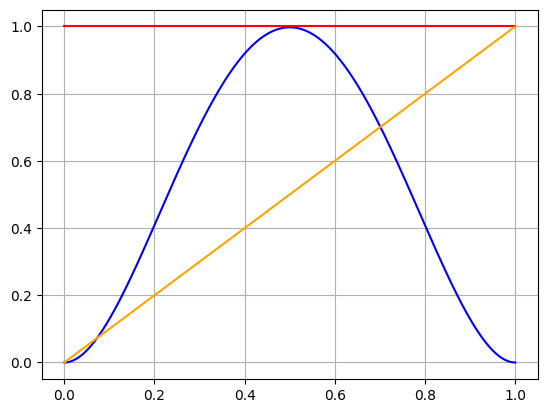

In [21]:
xbeta = np.linspace(0, 1, 1000)
plt.grid(True)
plt.plot(
    xbeta,
    (12*xbeta**2 * (1-xbeta)**2)/(1/1.33),
    color='blue'
)
plt.plot(
    xbeta,
    np.repeat([1-0], 1000),
    color='red'
    
)
plt.plot(xbeta,
        (xbeta - 0) / (1 - 0),
        color='orange'
        )

In [6]:
def beta_2_3(x):
    return 12*x**2 * (1-x)**2


## 5. Rejection sampling of a Gaussian with Laplace  (4 pts)

Consider the standard $\text{Laplace}(0, 1)$ distribution defined by:
$$ q(x) = 1/2 \exp(- | x | ),$$ 
and the standard normal distribution defined by
$$p(x) = \frac{1}{\sqrt{2 \pi}} \exp\left( - \frac{1}{2} x^2 \right).$$
For both the Laplace and normal distribution, $x \in (-\infty, \infty)$.

1. Write a program to draw samples from the $\text{Laplace}(0, 1)$ distribution. (*Hint*: transformation considered on Lecture 2.) Test your program by comparing the normed histogram of the samples with the density.
2. Design a method to draw samples from the standard normal using the standard Laplace distribution as the proposal. (*Hint*: you need to find a constant $M$ such that $p(x) \le M q(x)$ for all $x$. Plotting the function $p(x)/q(x)$ is again useful for looking for one.)
3. Use 10000 samples to compute the expectation $ E[x^4] $ for $ x $ following the standard normal distribution.
4. Assume the underlying uniform random generator uses full 53 bits of precision of `float64` and produces random numbers in the range $[2^{-53}, 1]$, that is the smallest number $u$ that can be generated is $2^{-53}$. Considering the same setup as above, what is the largest value the rejection sampling method can generate, if it were executed for long enough? 

Hints for part 5.4:
- You need to check that the algorithm can both generate an extreme value, and accept it.
- What's the equation for accepting a value in rejection sampling? In particular, the fact that $u$ cannot be smaller than $2^{-53}$ implies that there are some values of $x$ that you will never be able to accept. Figure out the maximum $x$ that you can accept!
- You can use the same $M$ that you used in part 5.2 (as long as you chose a reasonable $M$, the answer will be valid).